In [1]:
%matplotlib inline

from metapool.metapool import *

/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Workflow for calculating pooling

This notebook calculates pooling based on qPCR values, and produces visual outputs to interpret and check values. 

As inputs, this notebook requires:
1. qPCR output (tab-delimited text format with columns 'Cp' and 'Pos'
2. DNA input normalization pick list (comma-delimited text format Echo pick list used for DNA normalization)
3. Unique indices pick list (CSV text format Echo pick list, including sample names, used for index primer addition)

The workflow:
1. reads in qPCR output and calculates estimated library concentration
2. reads in DNA concentrations and graphs library concentration against DNA concentration
3. reads in indices and sample names and plots library concentration across plates
4. calculates pooling values and generates an Echo pick list

## Step 1: read in input files

Before the workflow starts, we'll provide the paths to each of the three input files in one location. 

**Enter the correct path to the file**, and then you can execute the following steps:

In [70]:
qpcr_input_fp = '/Users/cabrennan/Desktop/FinRisk_KHP/FinRisk_17-20/2017-8-16_Kinght_FinRisk_17-20_qPCR.txt'
dna_picklist_fp = '/Users/cabrennan/Desktop/FinRisk_KHP/FinRisk_17-20/Fin Risk 17-20 Input Norm - Echo Picklist.csv'
index_picklist_fp = '/Users/cabrennan/Desktop/FinRisk_KHP/FinRisk_17-20/Primer Plate 6-Table 1.csv'

for file in [qpcr_input_fp, dna_picklist_fp, index_picklist_fp]:
    if not os.path.isfile(file):
        print("Problem! %s is not a path to a valid file" % file)

### Read in qPCR output. 

This file should look something like this:

```
Experiment: 2017-05-19_Knight_CF+ABTX+AGP_KHP_rerun  Selected Filter: SYBR Green I / HRM Dye (465-510)
Include	Color	Pos	Name	Cp	Concentration	Standard	Status
True	255	A1	Sample 1	20.55		0	
True	255	A2	Sample 2	  9.15		0	
True	255	A3	Sample 3	  9.16		0	
True	255	A4	Sample 4	  8.89		0	
True	255	A5	Sample 5	  8.43		0	
True	255	A6	Sample 6	  8.66		0	
True	255	A7	Sample 7	  8.84		0	
True	255	A8	Sample 8	  8.85		0
```

In [71]:
qpcr_df = pd.read_csv(qpcr_input_fp, sep = '\t', skiprows=1, header=0)
qpcr_df.head()

,Include,Color,Pos,Name,Cp,Concentration,Standard,Status
0,True,255,A1,Sample 1,14.19,NaN,0,NaN
1,True,255,A2,Sample 2,17.43,NaN,0,NaN
2,True,255,A3,Sample 3,11.63,NaN,0,NaN
3,True,255,A4,Sample 4,9.85,NaN,0,NaN
4,True,255,A5,Sample 5,12.38,NaN,0,NaN


### Read in DNA norm pick list. 

This file should look something like this:

```
Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
water,384LDV_AQ_B2_HT,A1,,3420,NormalizedDNA,A1
water,384LDV_AQ_B2_HT,C1,,3442.5,NormalizedDNA,C1
water,384LDV_AQ_B2_HT,E1,,3477.5,NormalizedDNA,E1
water,384LDV_AQ_B2_HT,G1,,3322.5,NormalizedDNA,G1
water,384LDV_AQ_B2_HT,I1,,3142.5,NormalizedDNA,I1
water,384LDV_AQ_B2_HT,K1,,3330,NormalizedDNA,K1
water,384LDV_AQ_B2_HT,M1,,3345,NormalizedDNA,M1
water,384LDV_AQ_B2_HT,O1,,3477.5,NormalizedDNA,O1
water,384LDV_AQ_B2_HT,A3,,3447.5,NormalizedDNA,A3
```

In [72]:
dna_picklist = pd.read_csv(dna_picklist_fp, sep = ',', header = 0)
dna_picklist.loc[384:389]

,Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
384,1,384LDV_AQ_B2_HT,A1,0.0498,3500.0,NormalizedDNA,A1
385,1,384LDV_AQ_B2_HT,C1,4.2175,1187.5,NormalizedDNA,C1
386,1,384LDV_AQ_B2_HT,E1,8.8003,570.0,NormalizedDNA,E1
387,1,384LDV_AQ_B2_HT,G1,16.0297,312.5,NormalizedDNA,G1
388,1,384LDV_AQ_B2_HT,I1,2.8590,1750.0,NormalizedDNA,I1
389,1,384LDV_AQ_B2_HT,K1,0.0097,3500.0,NormalizedDNA,K1


### Read in index pick list.

This file should look something like this:

```
Well Number,Plate,Sample Name,Source Plate Name,Source Plate Type,Counter,Primer,Source Well,Index,,,,Transfer volume,Destination Well,
1,ABTX_35,8_29_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1841,iTru5_01_G,G1,GTTCCATG,iTru7_110_05,A23,CGCTTAAC,250,A1,
2,ABTX_35,8_29_13_rk_lh,iTru Source Plate,384LDV_AQ_B2_HT,1842,iTru5_01_H,H1,TAGCTGAG,iTru7_110_06,B23,CACCACTA,250,C1,
3,ABTX_35,8_30_13_rk_fh,iTru Source Plate,384LDV_AQ_B2_HT,1843,iTru5_02_A,I1,CTTCGCAA,iTru7_110_07,C23,ACAGCAAC,250,E1,
4,ABTX_35,8_30_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1844,iTru5_02_B,J1,GTGGTATG,iTru7_110_08,D23,GGAAGGAT,250,G1,
5,ABTX_35,8_30_13_rk_lh,iTru Source Plate,384LDV_AQ_B2_HT,1845,iTru5_02_C,K1,CACTGTAG,iTru7_110_09,E23,GGCGTTAT,250,I1,
6,ABTX_35,8_31_13_rk_lh,iTru Source Plate,384LDV_AQ_B2_HT,1846,iTru5_02_D,L1,AGACGCTA,iTru7_110_10,F23,CTGTTGAC,250,K1,
7,ABTX_35,8_31_13_rk_fh,iTru Source Plate,384LDV_AQ_B2_HT,1847,iTru5_02_E,M1,CAACTCCA,iTru7_110_11,G23,GTCATCGA,250,M1,
8,ABTX_35,8_31_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1848,iTru5_02_F,N1,AACACGCT,iTru7_110_12,H23,TGACTTCG,250,O1,
9,ABTX_35,9_1_13_rk_rh,iTru Source Plate,384LDV_AQ_B2_HT,1849,iTru5_02_G,O1,TGGATGGT,iTru7_111_01,I23,CGATAGAG,250,A3,
```

In [73]:
index_picklist = pd.read_csv(index_picklist_fp, sep = ',', header = 0)
index_picklist.head()

,Well Number,Plate,Sample Name,Source Plate Name,Source Plate Type,Counter,Primer,Source Well,Index,Unnamed: 9,Unnamed: 10,Unnamed: 11,Transfer volume,Destination Well
0,1,1,17-A1,i5 Source Plate,384LDV_AQ_B2_HT,1921,iTru5_06_A,I3,CGATCGAT,iTru7_109_01,A22,CTCGTCTT,250,A1
1,2,1,820034263-1,i5 Source Plate,384LDV_AQ_B2_HT,1922,iTru5_06_B,J3,TACTCCAG,iTru7_109_02,B22,CGAACTGT,250,C1
2,3,1,820036741-6,i5 Source Plate,384LDV_AQ_B2_HT,1923,iTru5_06_C,K3,AGCTACCA,iTru7_109_03,C22,CATTCGGT,250,E1
3,4,1,820046303-2,i5 Source Plate,384LDV_AQ_B2_HT,1924,iTru5_06_D,L3,TCGACAAG,iTru7_109_04,D22,TCGGTTAC,250,G1
4,5,1,820215145-6,i5 Source Plate,384LDV_AQ_B2_HT,1925,iTru5_06_E,M3,TATGACCG,iTru7_109_05,E22,AAGTCGAG,250,I1


## Step 2: merge sample information

This step will merge the information from each of the three files into a single data frame. 

In [74]:
combined_df = combine_dfs(qpcr_df, dna_picklist, index_picklist)
combined_df.head()

,Well,Cp,DNA Concentration,DNA Transfer Volume,Sample Name,Plate,Counter,Source Well i7,Index i7,Primer i7,Source Well i5,Index i5,Primer i5
0,A1,14.19,0.0498,3500.0,17-A1,1,1921,A22,CTCGTCTT,iTru7_109_01,I3,CGATCGAT,iTru5_06_A
1,A2,17.43,0.0461,3500.0,18-A1,2,2017,A22,CTCGTCTT,iTru7_109_01,K3,AGCTACCA,iTru5_06_C
2,A3,11.63,4.9478,1012.5,820203481-3,1,1929,I22,AGTCGCTT,iTru7_109_09,A1,ACCGACAA,iTru5_01_A
3,A4,9.85,10.4831,477.5,820224885-2,2,2025,I22,AGTCGCTT,iTru7_109_09,C1,CACAGACT,iTru5_01_C
4,A5,12.38,3.4466,1452.5,820204209-3,1,1937,A23,CGCTTAAC,iTru7_110_05,I1,CTTCGCAA,iTru5_02_A


## Step 3: calculate sample concentration

This step will calculate the estimated concentration based on Cp value. It will also add this info back to the sample data frame.

In [75]:
combined_df['Library Concentration'] = compute_qpcr_concentration(combined_df['Cp'])
combined_df.head()

,Well,Cp,DNA Concentration,DNA Transfer Volume,Sample Name,Plate,Counter,Source Well i7,Index i7,Primer i7,Source Well i5,Index i5,Primer i5,Library Concentration
0,A1,14.19,0.0498,3500.0,17-A1,1,1921,A22,CTCGTCTT,iTru7_109_01,I3,CGATCGAT,iTru5_06_A,5.475098
1,A2,17.43,0.0461,3500.0,18-A1,2,2017,A22,CTCGTCTT,iTru7_109_01,K3,AGCTACCA,iTru5_06_C,0.544009
2,A3,11.63,4.9478,1012.5,820203481-3,1,1929,I22,AGTCGCTT,iTru7_109_09,A1,ACCGACAA,iTru5_01_A,33.940344
3,A4,9.85,10.4831,477.5,820224885-2,2,2025,I22,AGTCGCTT,iTru7_109_09,C1,CACAGACT,iTru5_01_C,120.678324
4,A5,12.38,3.4466,1452.5,820204209-3,1,1937,A23,CGCTTAAC,iTru7_110_05,I1,CTTCGCAA,iTru5_02_A,19.887947


## Step 4: calculate pooling values

This step will calculate the sample pooling, and update the sample data frame with the pool info.

You can change some variables if you want different behavior:

- **min_conc**: This is the minimum concentration for a sample to be considered for pooling. Set to 0 to pool all samples, regardless of concentration. Increasing this will have the effect of increasing pool concentration, at the expense of samples dropping out. 
- **floor_conc**: This is the lowest concentration equivalent for which a sample will be accurately pooled. Samples below this concentration will be pooled to the volume that they would have been if they were actually that concentration. For example, if `floor_conc=20`, and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect of increasing pool concentration, but decreasing read counts for low-concentration samples. 
- **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing this will increase the overall volume of the pool. 

In [76]:
combined_df['Pooled Volume'] = compute_shotgun_pooling_values_qpcr(np.nan_to_num(combined_df['Library Concentration']),
                                        min_conc=20, floor_conc=40,
                                        total_nmol=.008)
combined_df.head()

,Well,Cp,DNA Concentration,DNA Transfer Volume,Sample Name,Plate,Counter,Source Well i7,Index i7,Primer i7,Source Well i5,Index i5,Primer i5,Library Concentration,Pooled Volume
0,A1,14.19,0.0498,3500.0,17-A1,1,1921,A22,CTCGTCTT,iTru7_109_01,I3,CGATCGAT,iTru5_06_A,5.475098,0.000000
1,A2,17.43,0.0461,3500.0,18-A1,2,2017,A22,CTCGTCTT,iTru7_109_01,K3,AGCTACCA,iTru5_06_C,0.544009,0.000000
2,A3,11.63,4.9478,1012.5,820203481-3,1,1929,I22,AGTCGCTT,iTru7_109_09,A1,ACCGACAA,iTru5_01_A,33.940344,607.902736
3,A4,9.85,10.4831,477.5,820224885-2,2,2025,I22,AGTCGCTT,iTru7_109_09,C1,CACAGACT,iTru5_01_C,120.678324,201.495253
4,A5,12.38,3.4466,1452.5,820204209-3,1,1937,A23,CGCTTAAC,iTru7_110_05,I1,CTTCGCAA,iTru5_02_A,19.887947,0.000000


The estimated pool volume and concentration are (concentration, nM; volume, nL):

In [77]:
estimate_pool_conc_vol(combined_df['Pooled Volume'], combined_df['Library Concentration'])

(123.17867001904418, 64097.55617474607)

## Step 5: visualization

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

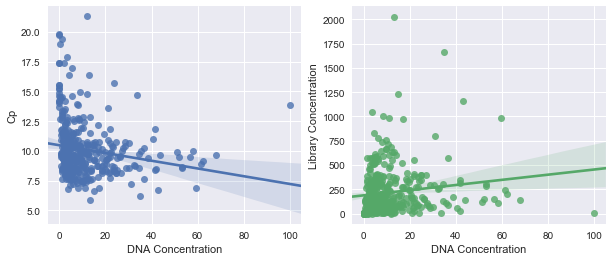

In [78]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.regplot(x="DNA Concentration", y="Cp", data=combined_df, ax = ax1);
sns.regplot(x="DNA Concentration", y="Library Concentration", data=combined_df, ax = ax2);

### Library concentration heatmap, whole plate

In [95]:
# get concentration and pooling values for plotting
concs = make_2D_array(combined_df, data_col="Library Concentration", well_col='Well').astype(float)
vols = make_2D_array(combined_df, data_col='Pooled Volume', well_col='Well').astype(float)
dna = make_2D_array(combined_df, data_col='DNA Concentration', well_col='Well').astype(float)

# get information for annotation
names = make_2D_array(combined_df, data_col='Sample Name', well_col='Well')
i5 = make_2D_array(combined_df, data_col='Primer i5', well_col='Well')
i7 = make_2D_array(combined_df, data_col='Primer i7', well_col='Well')

In [96]:
pd.DataFrame(dna).to_excel('384_5-8.xlsx')

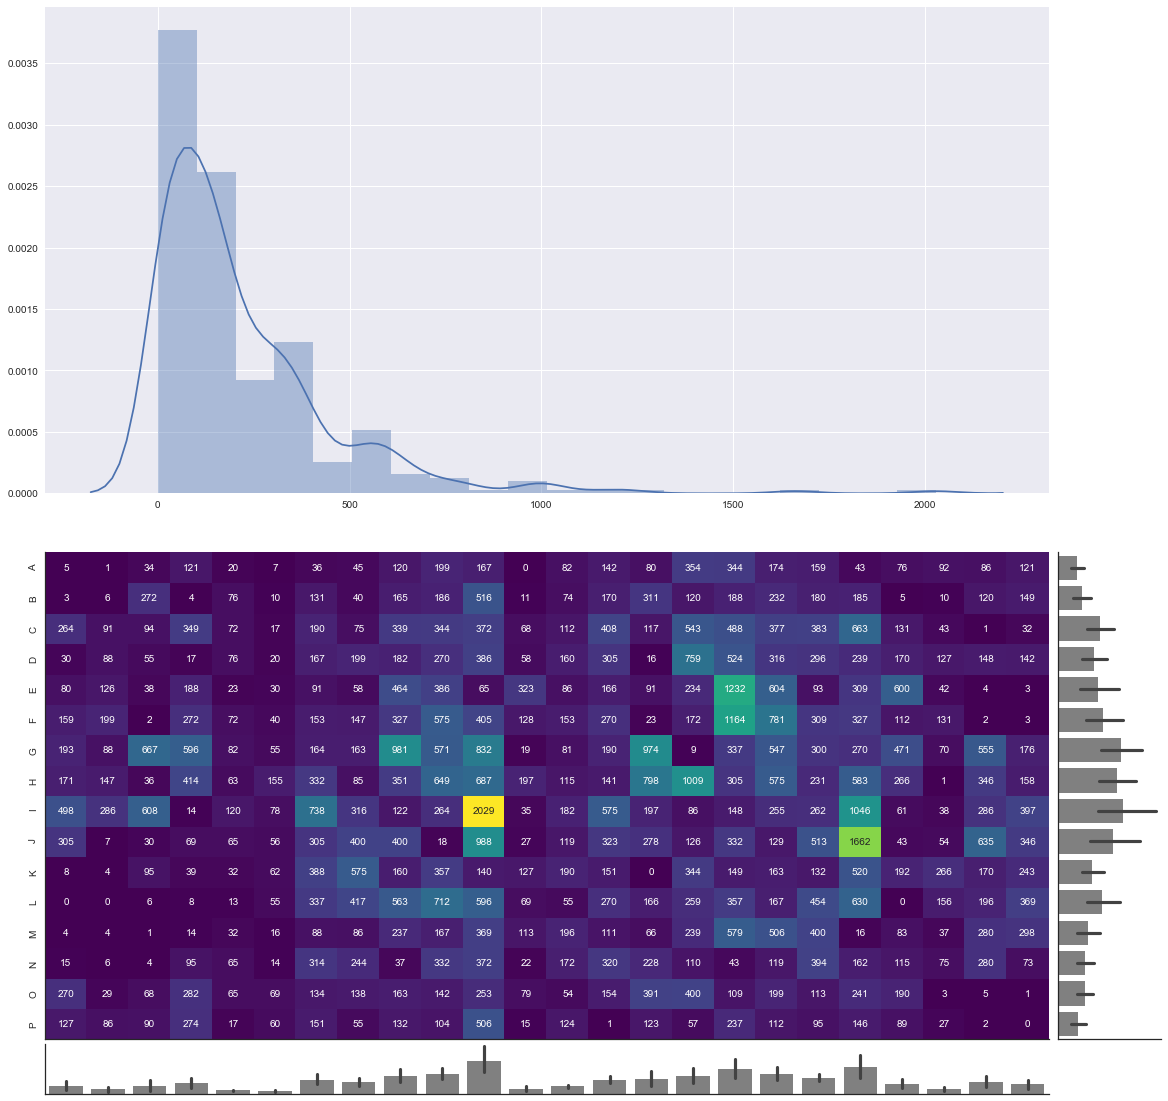

In [107]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

In [82]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### Library concentration heatmap, Plate 1

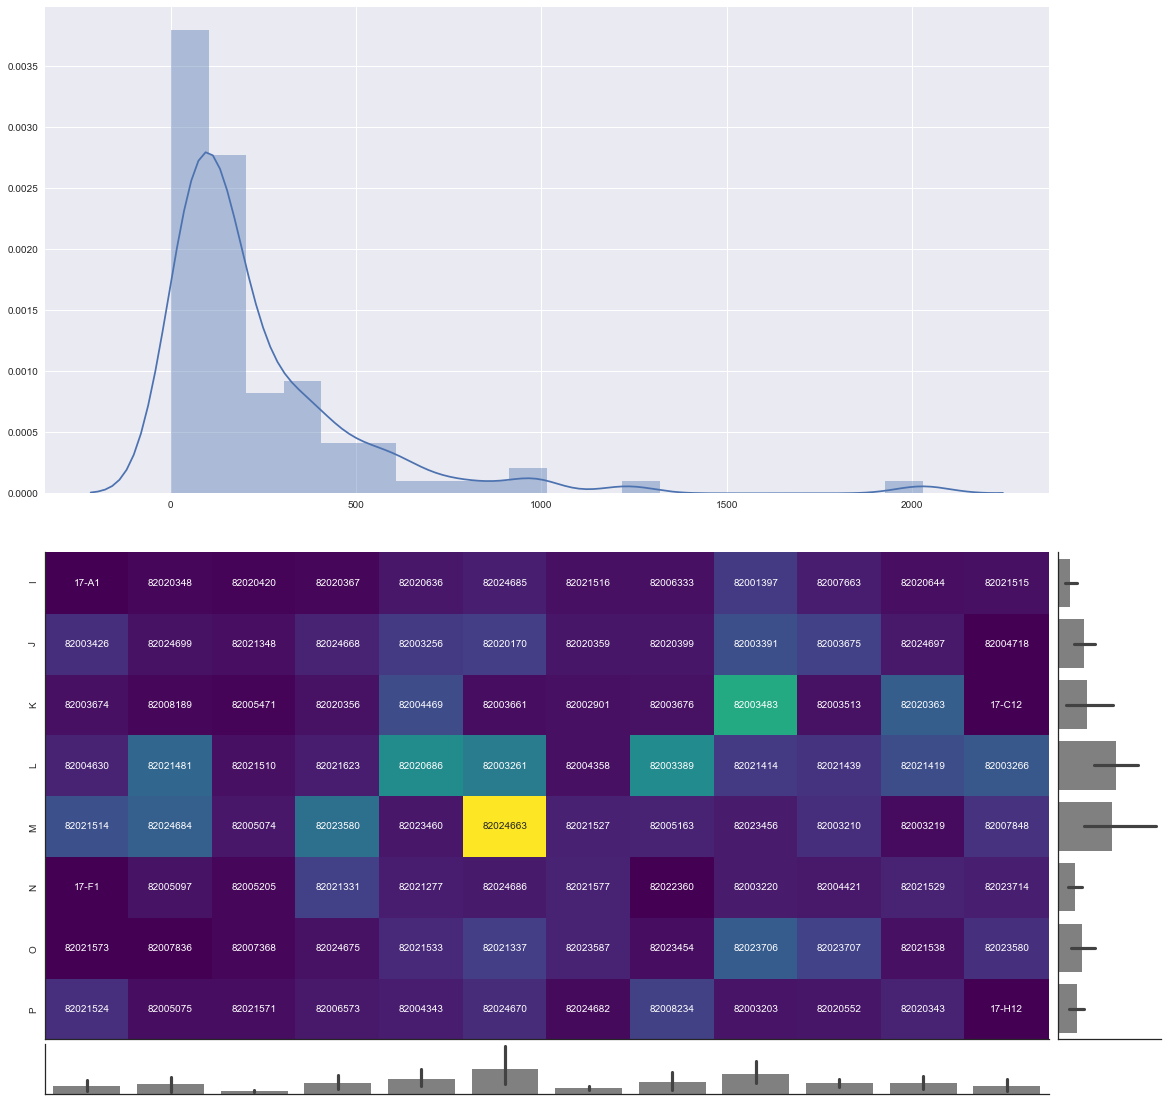

In [100]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='.8s')

### Library concentration heatmap, Plate 2

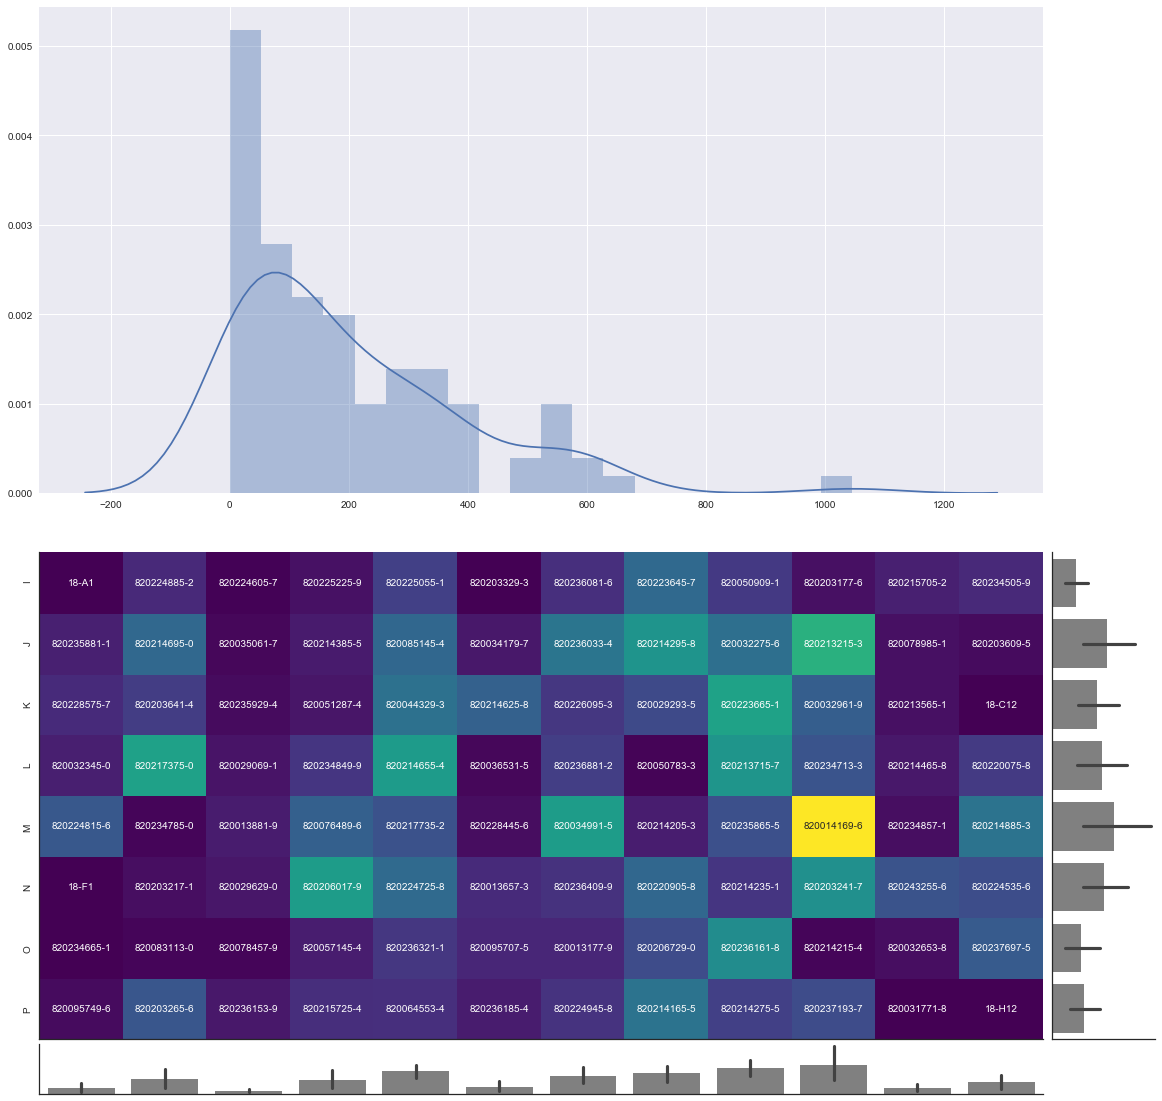

In [101]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 3

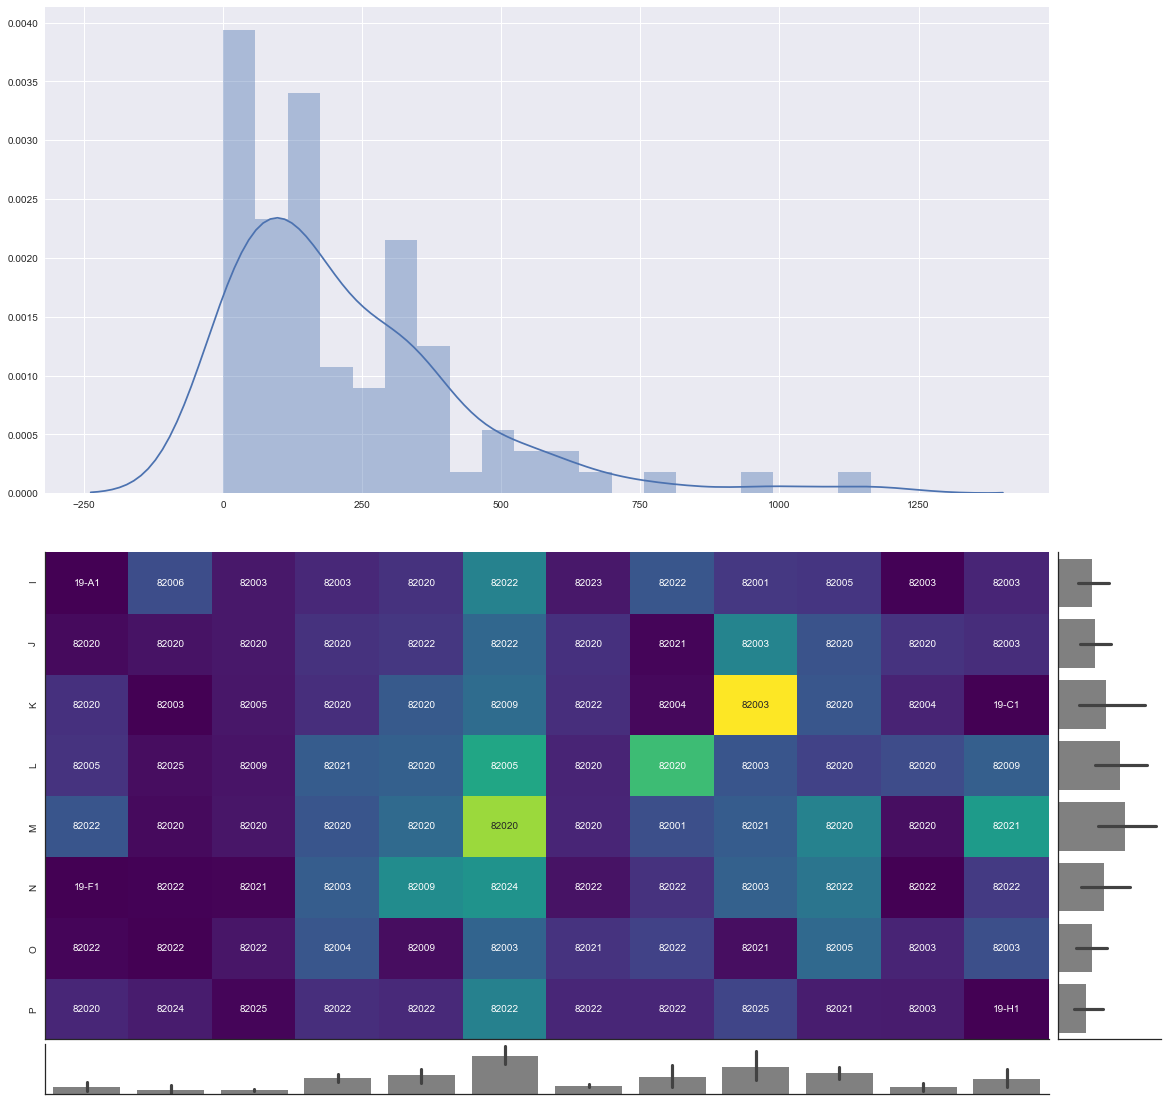

In [102]:
plot_plate_vals(concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='.5s')

### Library concentration heatmap, Plate 4

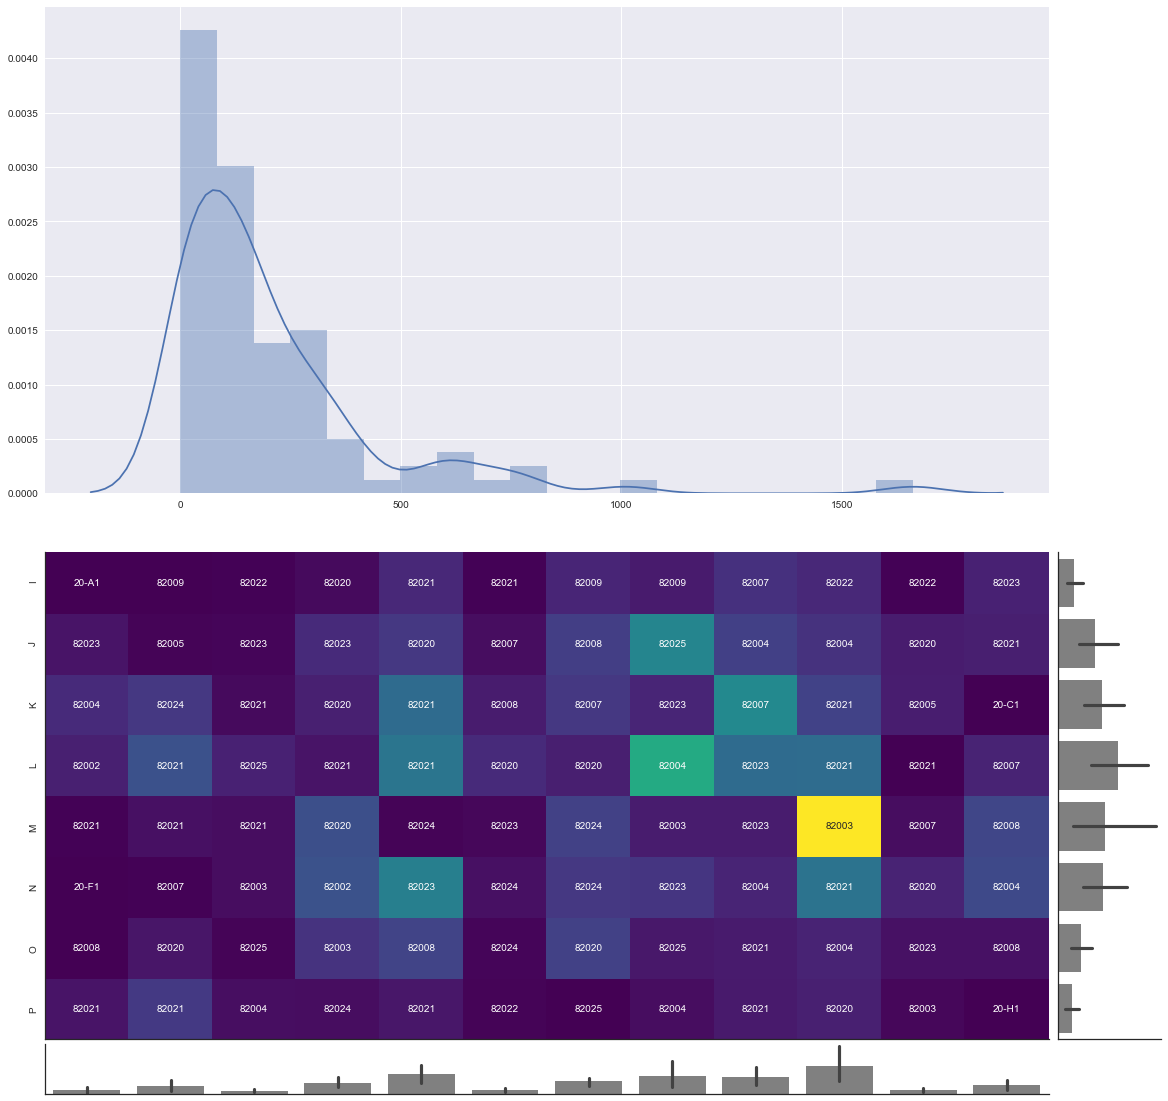

In [106]:
plot_plate_vals(concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='.5s')

### Plot pooling volumes

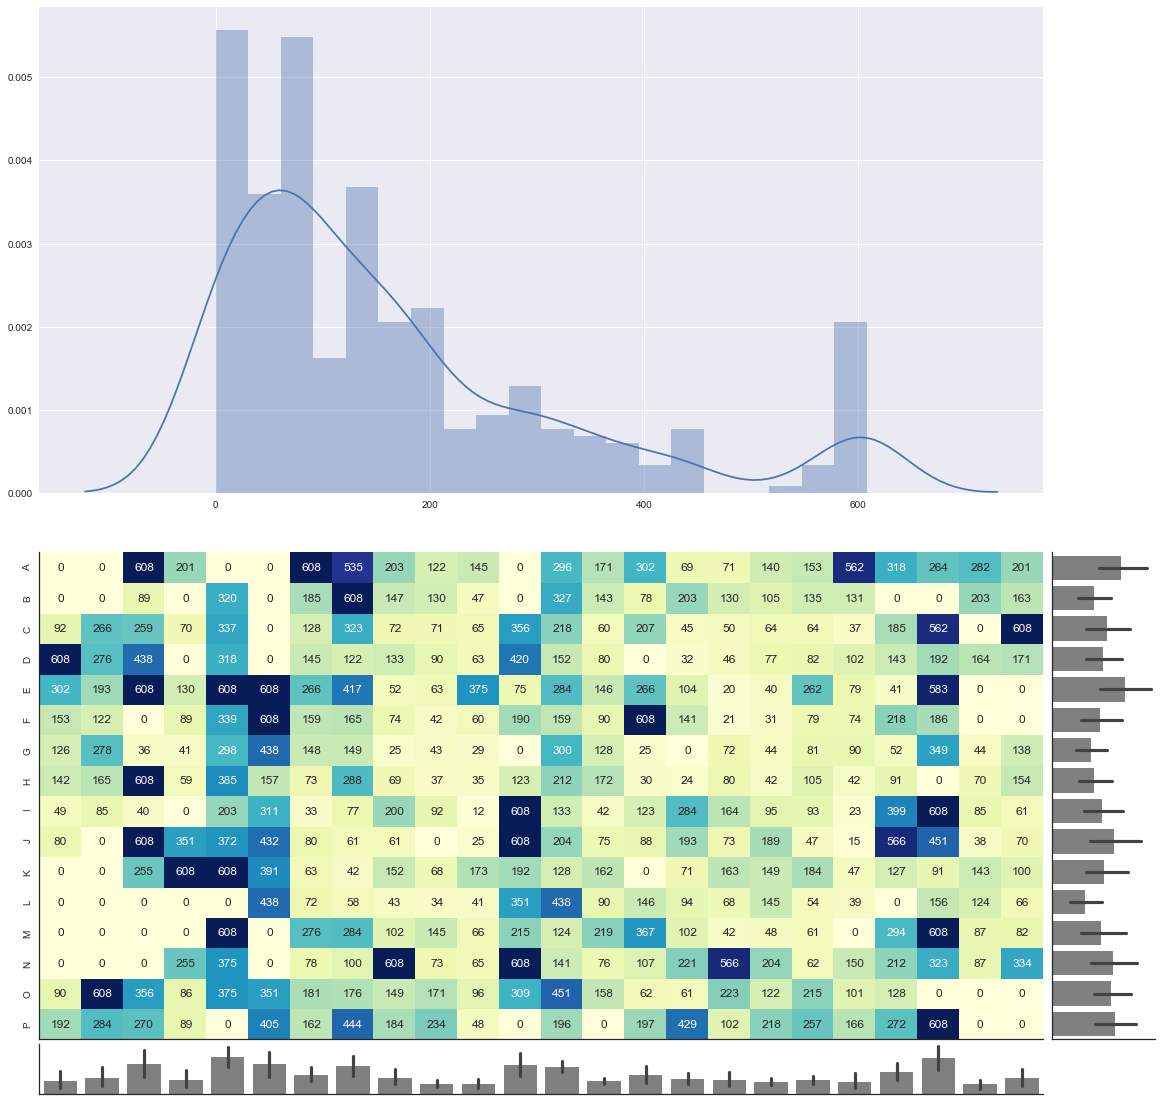

In [42]:
plot_plate_vals(vols)

## Step 6: write pooling pick list

In [43]:
# Write the picklist
picklist_fp = ''

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [24]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)
print(picklist)

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2_HT,A1,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A2,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A3,,306.91,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A4,,86.32,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A5,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A6,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A7,,289.90,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A8,,229.15,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A9,,86.93,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A10,,52.41,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A11,,62.19,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A12,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A13,,126.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A14,,73.27,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A15,,129.57,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A16,,29.43,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A17,,30.28,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A18,,60.01,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A19,,65.37,NormalizedDNA,A1
1,384LD